In [1]:
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import theano.tensor as tt
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\smrut\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# simple model

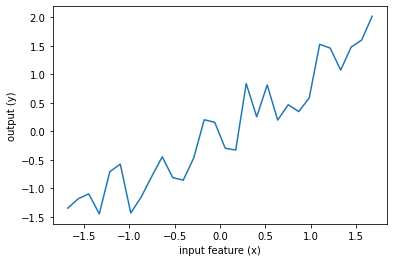

(30, 1)
(30,)


In [2]:
N = 30
X = np.linspace(0, 1, N)[:, None]
y = 3*X[:,0] + np.random.rand(N)
X = (X-X.mean(axis=0))/X.std(axis=0)
y = (y-y.mean(axis=0))/y.std(axis=0)

plt.plot(X, y)
plt.xlabel("input feature (x)")
plt.ylabel("output (y)")
plt.show();
print(X.shape)
print(y.shape)

In [14]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=X)
    σ = pm.HalfCauchy("σ", beta=5)
    y_obs = pm.Normal("y_obs", mu=f, sigma=σ, observed=y)
    trace = pm.find_MAP()

C:\Users\smrut\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = 429.37, ||grad|| = 8.4428e+06: : 5001it [07:43, 10.79it/s]                        



In [15]:
print("ℓ", trace["ℓ"])
print("η", trace["η"])
print("σ", trace["σ"])

ℓ 0.14511498243410914
η 4.356483153278613
σ 6.943151111163079e-08


In [16]:
# 200 new values from x=0 to x=15
n_new = 30
X_new = np.linspace(0, 3, n_new)[:,None]
X_new = (X_new-X.mean(axis=0))/X.std(axis=0)

# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# Sample from the GP conditional distribution
with model:
    pred_samples = pm.sample_posterior_predictive([trace], vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [02:11<00:00,  7.58it/s]


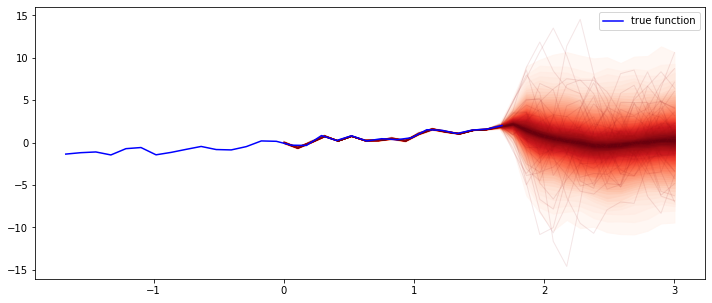

In [28]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_pred"], X_new);
plt.plot(X.flatten(), y, color="blue", label="true function");
plt.legend();
plt.show();

# iris dataset

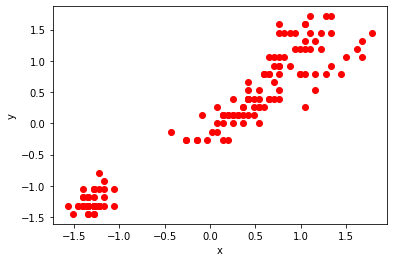

In [29]:
iris = datasets.load_iris()
X = iris.data
X = (X-X.mean(axis=0))/X.std(axis=0)
np.corrcoef(X.T)
x, y = X[:,2][:,None], X[:,3]
plt.scatter(x,y, color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [30]:
with pm.Model() as model:
    ℓ = 1
    η = 1
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=x)
    σ = pm.HalfCauchy("σ", beta=5)
    ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_obs = pm.StudentT("y_obs", mu=f, lam=1.0/σ, nu=ν, observed=y)
    trace = pm.sample(1000, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ν, σ, f_rotated_]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [45:43<00:00,  1.83s/it]   


In [31]:
dx = pd.DataFrame(np.hstack([x, trace["f"].T])).sort_values(by=[0])
sample = dx.iloc[:,1:].values.T
data = dx.iloc[:,0:1].values

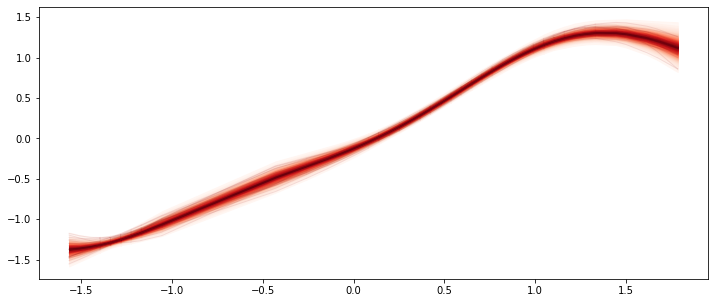

In [32]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, sample, data);

# Marginal GP

In [41]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfCauchy("σ", beta=5)
    y_ = gp.marginal_likelihood("y", X=x, y=y, noise=σ)

    mp = pm.find_MAP()

C:\Users\smrut\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -23.53, ||grad|| = 7.0242: 100%|██████████| 20/20 [01:40<00:00,  5.01s/it]     


In [42]:
n_new = 10
X_new = np.linspace(-1, 1, n_new)[:,None]

# add the GP conditional to the model, given the new X values
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[y_pred], samples=500)

100%|██████████| 500/500 [31:01<00:00,  3.72s/it]


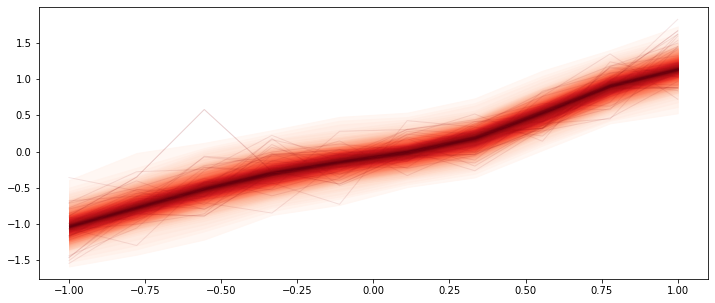

In [51]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["y_pred"], X_new);
plt.show();

C:\Users\smrut\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


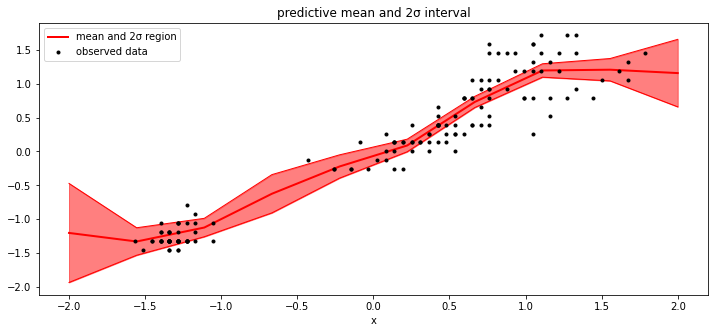

In [53]:
n_new = 10
X_new = np.linspace(-2, 2, n_new)[:,None]
# predict
mu, var = gp.predict(X_new, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(x, y, 'ok', ms=3, alpha=1.0, label="observed data");

plt.xlabel("x");
plt.title("predictive mean and 2σ interval"); plt.legend();